<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_Transverse%20field%20Ising%20model%20to%20demo-sampler%20primitives_mkbahk_20241015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install qiskit[visualization]=='1.2.4'
%pip install qiskit_ibm_runtime=='0.30.0'
%pip install qiskit_aer=='0.15.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d594a8aecbe0c14cb5daa03bc5ff8c74f3cb3c59b51cdddda6211c8aa7e47151
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip show qiskit qiskit_ibm_runtime qiskit_aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for 

In [ ]:
%pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.7.0.32.46
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread        

In [ ]:
import qiskit
qiskit.__version__

'1.2.4'

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.__version__

'0.30.0'

In [ ]:
import qiskit_aer
qiskit_aer.__version__

'0.15.1'

# Transverse field Ising model to demo primitives

In [ ]:
#아래 circuit은 estimator primitive를 위한 것

from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label="$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label="$\sqrt{Y}^\dagger$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers = False, layer_barriers = False):
  if num_cl_bits == 0:
    qc = QuantumCircuit(num_qubits)
  else:
    qc = QuantumCircuit(num_qubits, num_cl_bits)
  ###if

  for trotter_step in range(num_trotter_steps):
    add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

  return qc
###def

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  # Adding Rzz in the even layers
  for i in range(0, qc.num_qubits - 1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the even layers
  for i in range(1, qc.num_qubits - 1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  qc.rx(rx_angle, list(range(qc.num_qubits)))

  if layer_barriers:
    qc.barrier()
  ###if
  return qc

###def



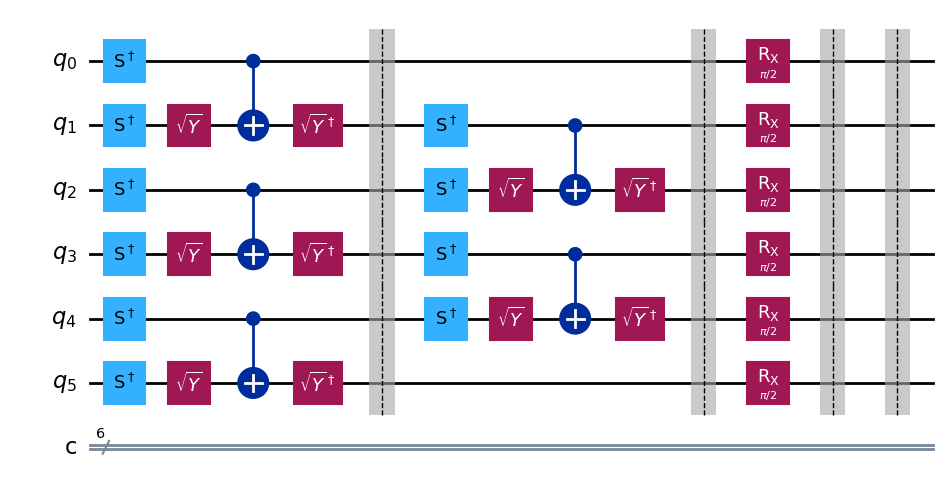

In [ ]:
num_qubits = 6
num_cl_bits = 6
num_trotter_steps = 1
rx_angle = np.pi/2

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold = -1)

# Demo Sampler

In [ ]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

  for trotter_step in range(num_trotter_steps):
    add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

###def

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  qc.rx(-rx_angle, list(range(qc.num_qubits)))

  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the odd layers
  for i in range(1, qc.num_qubits - 1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i, i+1])
  ###for

  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the odd layers
  for i in range(0, qc.num_qubits - 1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i, i+1])
  ###for

  if layer_barriers:
    qc.barrier()
  ###if

###def

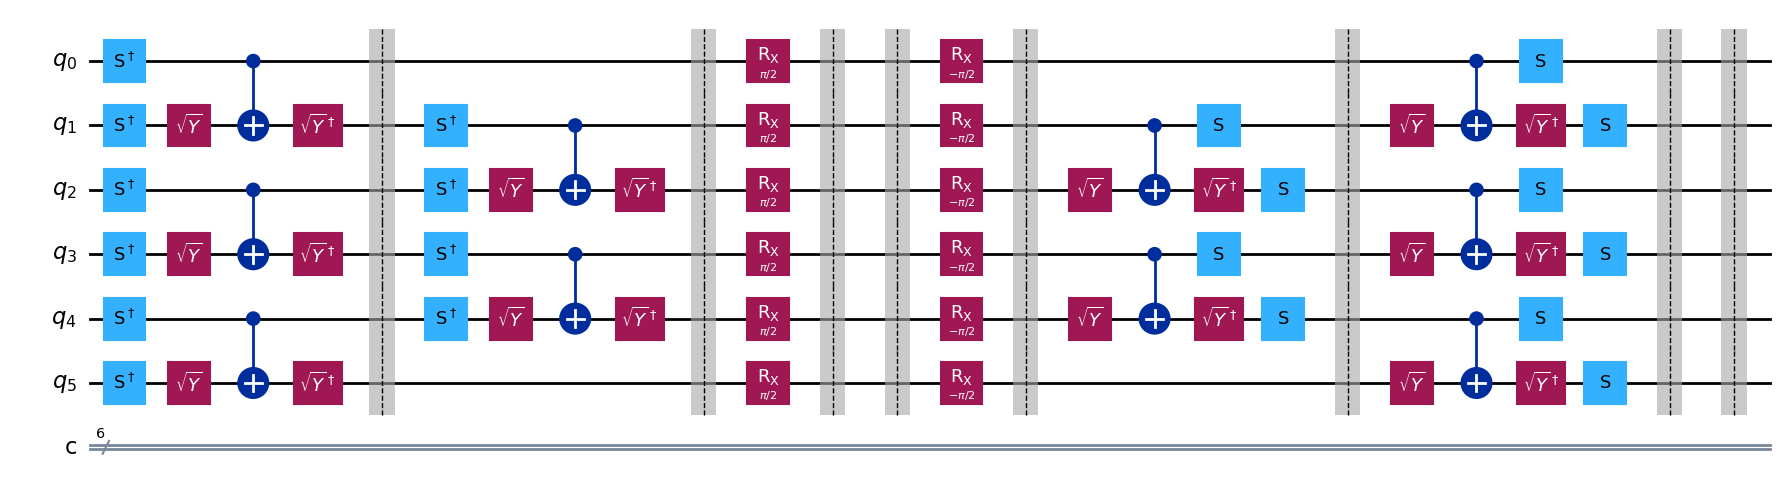

In [ ]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold = -1)

# Step 1: Map the problem to circuit and observables

In [ ]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_steps in range(max_trotter_steps):
  qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
  append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
  qc.measure(measured_qubits, list(range(len(measured_qubits))))
  qc_list.append(qc)
###for


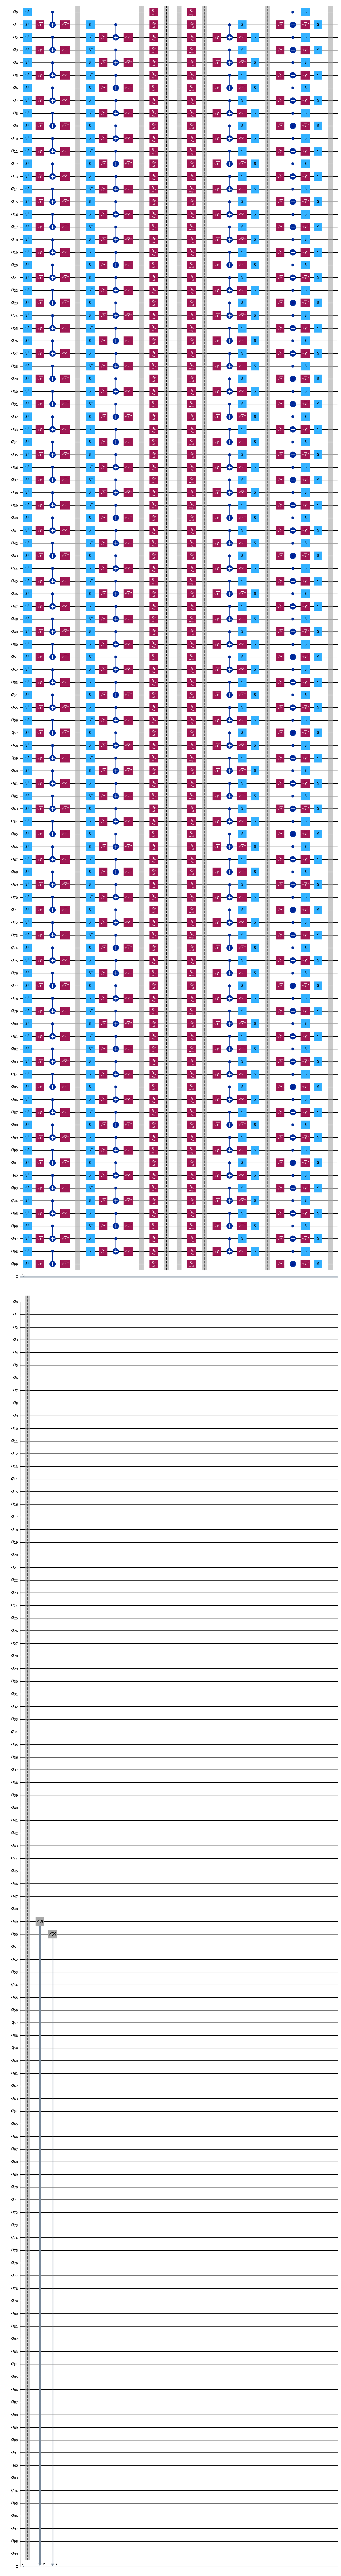

In [ ]:
qc_list[1].draw(output='mpl')

#Step 2: Optimize

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService()

In [ ]:
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [ ]:
backend = service.backend("ibm_brisbane")
print("Done getting the backend = ", backend)

Done getting the backend =  <IBMBackend('ibm_brisbane')>


In [ ]:
from qiskit import transpile

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

In [ ]:
qc_transpiled_list.draw(output='mpl', fold = -1)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list, shots=100)

print(f">>> Job ID: {job.job_id()}")

cw87wskjyrs0008gt7qg


#Step 4: Post-processing and plotting

In [ ]:
job_id = "cw87wskjyrs0008gt7qg"
job = service.job(job_id)
print(job.status())

DONE


In [ ]:
survival_probability_list = []
for trotter_steps in range(max_trotter_steps):
  try:
    data = job.result()[trotter_steps].data
    survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / (data.c.num_shots))
  except:
    survival_probability_list.append(0)
  ###try
###for

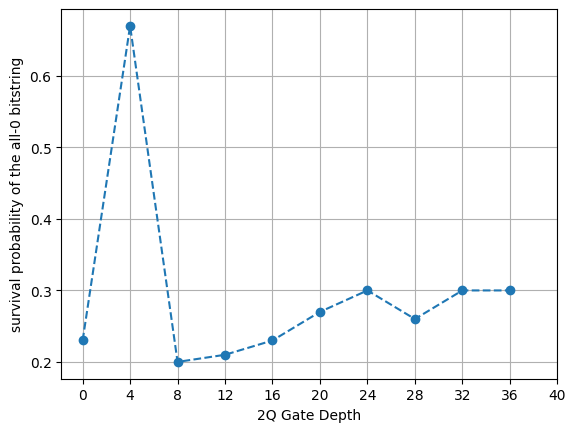

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel("2Q Gate Depth")
plt.ylabel("survival probability of the all-0 bitstring")
plt.xticks(list(range(0, 44, 4)))
plt.grid()
plt.show()